### Environment Setup

In [255]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import random
import numpy as np
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torchvision
import torchvision.transforms as transforms

batch_size = 64
num_classes = 3
learning_rate = 0.001
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [244]:
root_dir = os.getcwd() + '/data_processing'
image_dir = root_dir + '/all_images/'
train_dir = root_dir + '/train/'
test_dir = root_dir + '/test/'
val_dir = root_dir + '/val/'

In [171]:
train_labels_file = root_dir + '/train_labels.pt'
val_labels_file = root_dir + '/val_labels.pt'
test_labels_file = root_dir + '/test_labels.pt'

In [172]:
len(os.listdir(image_dir))

9207

In [173]:
for file in os.listdir(image_dir):
    assert file.endswith(".jpg")

In [174]:
model_dir = os.getcwd() + '/model_LSTM/'

### Dataloader

In [245]:
class FaceSet(data.Dataset):
    def __init__(self,folder,transform):
        self.transform=transform
        imgs=[os.path.join(folder,f) for f in os.listdir(folder)]
        self.imgs = imgs
        
    def __getitem__(self,index):
        imgpath=self.imgs[index]
        if os.path.exists(imgpath):
            try:
                im=Image.open(imgpath)
            except:
                return
            if im.mode == "RGBA":
                r, g, b, a=im.split ()
                im=Image.merge ("RGB", (r, g, b))
            elif im.mode!="RGB":
                im=im.convert ("RGB")
            im=self.transform(im)
            symbol = imgpath.split('/')[-1].split('.')[0].split('_')[-1]
            
            if symbol == "0" or symbol == "nomask":
                label = 0
            elif symbol == "1" or symbol == "face":
                label = 1
            else:
                label = 2

        return im,label
    def __len__(self):
        return len(self.imgs)

In [246]:
transform_train=transforms.Compose([ 
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
transform_test=transforms.Compose([ 
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

for fn in os.listdir(image_dir):
    im=Image.open(image_dir + fn)
    print(transform_train(im).size())
    break

torch.Size([3, 32, 32])


In [250]:
# define dataset
trainset=FaceSet(train_dir,transform=transform_train)
valset=FaceSet(val_dir,transform=transform_test)
testset=FaceSet(test_dir,transform=transform_test)

### Model Architecture

In [200]:
class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(LSTM, self).__init__()
        
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.fc = nn.Linear(3 * 32 * 32, input_dim, bias=True)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        feature = self.fc(x.flatten(1))
        feature,_ = self.lstm(self.relu(feature.unsqueeze(1)))
        output = self.fc2(feature.flatten(1))
        
        return output


In [251]:
bs = batch_size
train_loader=torch.utils.data.DataLoader(trainset,batch_size=bs,shuffle=True,num_workers=0)
val_loader=torch.utils.data.DataLoader(valset,batch_size=bs,shuffle=False,num_workers=0)
test_loader=torch.utils.data.DataLoader(testset,batch_size=bs,shuffle=False,num_workers=0)

### Train and Evaluation

In [202]:
#instatiate the model
INPUT_DIM = 512
OUTPUT_DIM = 3
HIDDEN_DIM = 128
N_LAYERS = 1
model = LSTM(input_dim = INPUT_DIM, output_dim = OUTPUT_DIM, hidden_dim = HIDDEN_DIM, n_layers = N_LAYERS)
model = model.to(device)
print(model)

LSTM(
  (fc): Linear(in_features=3072, out_features=512, bias=True)
  (relu): ReLU()
  (lstm): LSTM(512, 128)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [228]:
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_step = len(train_loader)

In [229]:
total_step = len(train_loader)

epoch_num = range(num_epochs)
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

for epoch in range(num_epochs):
    
    ### Train
    correct = 0
    total = 0
    running_loss = 0.0
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_acc = correct / total
    train_loss = running_loss / (i+1)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
        
    print ('Train Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
    .format(epoch+1, num_epochs, i+1, total_step, train_loss, train_acc))
    
    ### Evaluation
    correct = 0
    total = 0
    running_loss = 0.0
    model.eval()
    for i, (images, labels) in enumerate(val_loader):  
        images = images.to(device)
        labels = labels.to(device)
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
        
    val_acc = correct / total
    val_loss = running_loss / (i+1)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
        
    print ('Val Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
    .format(epoch+1, num_epochs, i+1, total_step, val_loss, val_acc))

Train Epoch [1/10], Step [14/14], Loss: 0.8635, Accuracy: 0.6127
Val Epoch [1/10], Step [3/14], Loss: 0.6568, Accuracy: 0.7102
Train Epoch [2/10], Step [14/14], Loss: 0.4926, Accuracy: 0.8188
Val Epoch [2/10], Step [3/14], Loss: 0.4778, Accuracy: 0.8011
Train Epoch [3/10], Step [14/14], Loss: 0.2947, Accuracy: 0.8913
Val Epoch [3/10], Step [3/14], Loss: 0.3939, Accuracy: 0.8466
Train Epoch [4/10], Step [14/14], Loss: 0.1849, Accuracy: 0.9377
Val Epoch [4/10], Step [3/14], Loss: 0.3896, Accuracy: 0.8636
Train Epoch [5/10], Step [14/14], Loss: 0.1204, Accuracy: 0.9683
Val Epoch [5/10], Step [3/14], Loss: 0.3818, Accuracy: 0.8807
Train Epoch [6/10], Step [14/14], Loss: 0.0833, Accuracy: 0.9773
Val Epoch [6/10], Step [3/14], Loss: 0.4260, Accuracy: 0.8693
Train Epoch [7/10], Step [14/14], Loss: 0.0648, Accuracy: 0.9841
Val Epoch [7/10], Step [3/14], Loss: 0.4934, Accuracy: 0.8409
Train Epoch [8/10], Step [14/14], Loss: 0.0488, Accuracy: 0.9875
Val Epoch [8/10], Step [3/14], Loss: 0.4075, A

### Test

In [252]:
### Test
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test set: {} %'.format(100 * correct / total))

Accuracy of the network on the test set: 81.48148148148148 %


### visualization

In [259]:
train_lossli=np.array(train_loss_list)
val_lossli=np.array(val_loss_list)
train_accli=np.array(train_acc_list)
val_accli=np.array(val_acc_list)
np.savetxt(model_dir+'/LSTM_train_loss.txt',train_lossli)
np.savetxt(model_dir+'/LSTM_val_loss.txt',val_lossli)
np.savetxt(model_dir+'/LSTM_train_acc.txt',train_accli)
np.savetxt(model_dir+'/LSTM_val_acc.txt',val_accli)

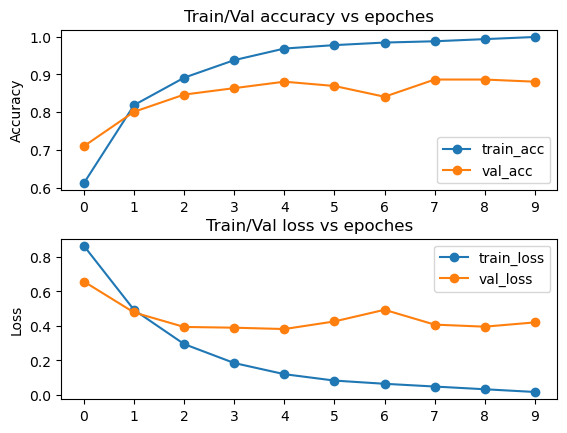

In [253]:
from matplotlib.pyplot import MultipleLocator
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.plot(epoch_num, train_acc_list, 'o-', label='train_acc')
plt.plot(epoch_num, val_acc_list, 'o-', label='val_acc')
plt.legend()
plt.title('Train/Val accuracy vs epoches')
x = MultipleLocator(1)
ax = plt.gca()
ax.xaxis.set_major_locator(x)
plt.ylabel('Accuracy')
plt.subplots_adjust(wspace=0, hspace=0.3)
plt.subplot(2, 1, 2)
plt.plot(epoch_num, train_loss_list, 'o-', label='train_loss')
plt.plot(epoch_num, val_loss_list, 'o-', label='val_loss')
plt.legend()
plt.title('Train/Val loss vs epoches')
x = MultipleLocator(1)
ax = plt.gca()
ax.xaxis.set_major_locator(x)
plt.ylabel('Loss')
plt.show()

### Reference

Hochreiter, Sepp & Schmidhuber, Jürgen. (1997). Long Short-term Memory. Neural computation. 9. 1735-80. 10.1162/neco.1997.9.8.1735. 

Sherstinsky A. Fundamentals of recurrent neural network (RNN) and long short-term memory (LSTM) network[J]. Physica D: Nonlinear Phenomena, 2020, 404: 132306.